In [11]:
# 1) Load the merged master file
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

MASTER = Path.home() / "Desktop/hbn_project/data/interim/NIH_TempDisc_pheno_diagnosis.csv"
df = pd.read_csv(MASTER, low_memory=False)
print(df.shape)

(2076, 180)


Temp_Disc_run1_k: ['assessment Temp_Disc_Final,Temp_Disc_run1_k']
Temp_Disc_run2_k: ['assessment Temp_Disc_Final,Temp_Disc_run2_k']
Temp_Disc_run1_ed50: ['assessment Temp_Disc_Final,Temp_Disc_run1_ed50']
Temp_Disc_run2_ed50: ['assessment Temp_Disc_Final,Temp_Disc_run2_ed50']


,n_missing,missing_pct,n_rows,n_present
"assessment Temp_Disc_Final,Temp_Disc_run2_k",63,3.0%,2076,"2,013"
"assessment Temp_Disc_Final,Temp_Disc_run2_ed50",63,3.0%,2076,"2,013"
"assessment Temp_Disc_Final,Temp_Disc_run1_k",46,2.2%,2076,"2,030"
"assessment Temp_Disc_Final,Temp_Disc_run1_ed50",46,2.2%,2076,"2,030"


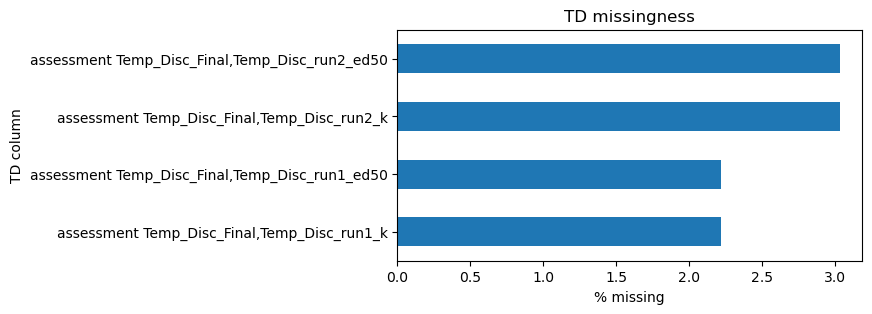

,n_participants,pct_participants
"[0.0, 0.1)","1,985",95.6%
"[0.1, 0.2)",0,0.0%
"[0.2, 0.3)",0,0.0%
"[0.3, 0.4)",0,0.0%
"[0.4, 0.5)",0,0.0%
"[0.5, 0.6)",73,3.5%
"[0.6, 0.7)",0,0.0%
"[0.7, 0.8)",0,0.0%
"[0.8, 0.9)",0,0.0%
"[0.9, 1.0)",0,0.0%


In [12]:
# --- Helper: find columns even if prefixed like 'assessment Temp_Disc_Final,Temp_Disc_run1_k' ---
def find_col(df, tail):
    tail_low = tail.lower()
    cands = [c for c in df.columns
             if c.lower().endswith(tail_low) or c.split(",")[-1].strip().lower()==tail_low]
    print(f"{tail}: {cands[:3] if len(cands)>3 else cands}")
    return cands[0] if cands else None

k1   = find_col(df, "Temp_Disc_run1_k")
k2   = find_col(df, "Temp_Disc_run2_k")
ed1  = find_col(df, "Temp_Disc_run1_ed50")
ed2  = find_col(df, "Temp_Disc_run2_ed50")

key_cols = [c for c in [k1,k2,ed1,ed2] if c is not None]
assert len(key_cols)>0, "No TD columns detected—inspect the file headers."

# --- Coerce to numeric (handles strings like '24' etc.) ---
df[key_cols] = df[key_cols].apply(pd.to_numeric, errors="coerce")

miss_tbl = (
    df[key_cols].isna()
      .agg(["sum","mean"]).T
      .rename(columns={"sum":"n_missing","mean":"missing_pct"})
      .assign(n_rows=len(df), n_present=lambda x: x.n_rows - x.n_missing)
      .sort_values("missing_pct", ascending=False)
)
display(miss_tbl.style.format({"missing_pct":"{:.1%}","n_missing":"{:,.0f}","n_present":"{:,.0f}"}))

# Optional bar chart
(miss_tbl["missing_pct"]*100).sort_values().plot(kind="barh", figsize=(6,3))
plt.xlabel("% missing"); plt.ylabel("TD column"); plt.title("TD missingness"); plt.show()

# --- 2) Per-participant completeness across key TD fields ---
row_miss = df[key_cols].isna().mean(axis=1)
bins = pd.cut(row_miss, bins=[0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0], right=False)
row_summary = bins.value_counts().sort_index().to_frame("n_participants")
row_summary["pct_participants"] = row_summary["n_participants"]/len(df)
display(row_summary.style.format({"n_participants":"{:,.0f}","pct_participants":"{:.1%}"}))


In [13]:
# 2) Helper to find a column whose name look like "assessment Temp_Disc_Final,Temp_Disc_run1_k")
def find_col_endswith(frame, suffix):
    hits = [c for c in frame.columns if re.search(rf"{re.escape(suffix)}$", c)]
    if not hits:
        print(f"❗Couldn't find a column ending with: {suffix}")
        return None
    if len(hits) > 1:
        print(f"ℹ️ Multiple matches for {suffix}: {hits}  (using the first)")
    return hits[0]

# Find the four key TD columns inside the merged file
k1_name  = find_col_endswith(df, "Temp_Disc_run1_k")
k2_name  = find_col_endswith(df, "Temp_Disc_run2_k")
ed1_name = find_col_endswith(df, "Temp_Disc_run1_ed50")
ed2_name = find_col_endswith(df, "Temp_Disc_run2_ed50")

print("Found TD cols:")
print(" run1 k   ->", k1_name)
print(" run2 k   ->", k2_name)
print(" run1 ed50->", ed1_name)
print(" run2 ed50->", ed2_name)

Found TD cols:
 run1 k   -> assessment Temp_Disc_Final,Temp_Disc_run1_k
 run2 k   -> assessment Temp_Disc_Final,Temp_Disc_run2_k
 run1 ed50-> assessment Temp_Disc_Final,Temp_Disc_run1_ed50
 run2 ed50-> assessment Temp_Disc_Final,Temp_Disc_run2_ed50


In [14]:
# 3) Create clean, short names and coerce to numeric 
rename_map = {}
if k1_name:  rename_map[k1_name]  = "k1"
if k2_name:  rename_map[k2_name]  = "k2"
if ed1_name: rename_map[ed1_name] = "ed50_1"
if ed2_name: rename_map[ed2_name] = "ed50_2"

df = df.rename(columns=rename_map)

def to_num(s):
    # remove commas/whitespace; turn non-numeric tokens into NaN
    return pd.to_numeric(
        s.astype(str).str.replace(",", "", regex=False).str.strip().replace({"": np.nan, "NA": np.nan, "null": np.nan}),
        errors="coerce"
    )

for c in ["k1","k2","ed50_1","ed50_2"]:
    if c in df.columns:
        df[c] = to_num(df[c])

df[["k1","k2","ed50_1","ed50_2"]].head()

,k1,k2,ed50_1,ed50_2
0,0.000110,0.000110,9131.250000,9131.250000
1,0.039552,0.000279,25.283196,3578.704514
2,0.000279,0.000110,3578.704514,9131.250000
3,0.000129,0.000612,7748.122555,1633.447658
4,0.013412,0.004742,74.562468,210.894506


In [15]:
# 4) Check: (1/k) should be close to ed50 (both in DAYS)
for kcol, dcol in [("k1","ed50_1"), ("k2","ed50_2")]:
    if kcol in df.columns and dcol in df.columns:
        ok = df[kcol].gt(0) & df[dcol].notna()
        ratio = (1.0/df.loc[ok, kcol]) / df.loc[ok, dcol]
        print(f"Median((1/{kcol})/{dcol}) =", np.nanmedian(ratio))

Median((1/k1)/ed50_1) = 1.0000000000795326
Median((1/k2)/ed50_2) = 1.0000000010477104


In [20]:
# 5) Build analysis features to be use later
if "k1" in df and "k2" in df:
    df["k_mean"]     = df[["k1","k2"]].mean(axis=1, skipna=True)
    df["logk_mean"]  = np.log(df["k_mean"].clip(lower=1e-6))
if "ed50_1" in df and "ed50_2" in df:
    df["ed50_mean"]  = df[["ed50_1","ed50_2"]].mean(axis=1, skipna=True)
df["k_abs_diff"] = (df.get("k1", np.nan) - df.get("k2", np.nan)).abs()

df[[c for c in ["k1","k2","k_mean","logk_mean","ed50_1","ed50_2","ed50_mean","k_abs_diff"] if c in df.columns]].head()

,k1,k2,k_mean,logk_mean,ed50_1,ed50_2,ed50_mean,k_abs_diff
0,0.000110,0.000110,0.000110,-9.119458,9131.250000,9131.250000,9131.250000,0.000000
1,0.039552,0.000279,0.019916,-3.916247,25.283196,3578.704514,1801.993855,0.039273
2,0.000279,0.000110,0.000194,-8.545220,3578.704514,9131.250000,6354.977257,0.000170
3,0.000129,0.000612,0.000371,-7.900298,7748.122555,1633.447658,4690.785106,0.000483
4,0.013412,0.004742,0.009077,-4.702051,74.562468,210.894506,142.728487,0.008670


In [21]:
# 6) Save back out with the TD columns included
OUT = MASTER.with_name("NIH_TempDisc_pheno_diagnosis_withTD.csv")
df.to_csv(OUT, index=False)
OUT

PosixPath('/Users/yizj/Desktop/hbn_project/data/interim/NIH_TempDisc_pheno_diagnosis_withTD.csv')